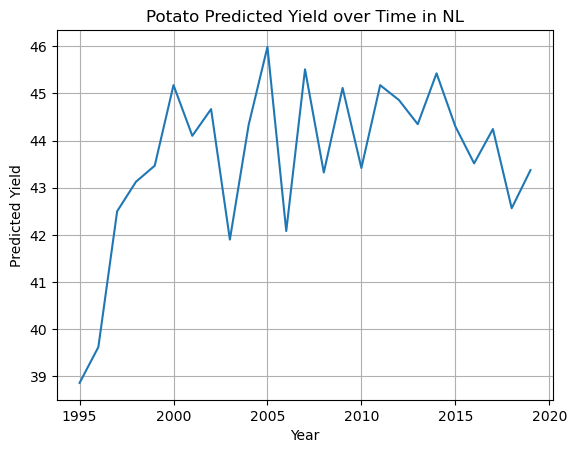

Initial Params: [0.01 0.1  0.2 ]
Initial Likelihood: -1580.4753428063364
`xtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 172, CG iterations: 50, optimality: 3.83e-04, constraint violation: 0.00e+00, execution time: 0.039 s.
Final Params: [1.54281457e-06 3.32219258e-01 2.99999891e+00]
Final Likelihood: -114.90384545996898

Kessler MLE: 
params      | [1.54281457e-06 3.32219258e-01 2.99999891e+00] 
sample size | 24 
likelihood  | -114.90384545996898 
AIC         | 235.80769091993795
BIC         | 239.3418524109818
Initial Params: [0.01 0.1  0.2 ]
Initial Likelihood: -1580.507524211356
`xtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 116, CG iterations: 40, optimality: 2.91e-02, constraint violation: 0.00e+00, execution time: 0.023 s.
Final Params: [1.93597945e-04 4.51244915e-01 2.99989281e+00]
Final Likelihood: -114.91422662626107

Shoji-Ozaki MLE: 
params      | [1.93597945e-04 4.51244915e-01 2.99989281

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from pymle.core.Model import Model1D
from typing import Union

# Step 1: Define the Ornstein-Uhlenbeck model (reuse from above)
class OrnsteinUhlenbeck(Model1D):
    def __init__(self):
        super().__init__(has_exact_density=True)

    def drift(self, x: Union[float, np.ndarray], t: float) -> Union[float, np.ndarray]:
        return self._params[0] * (self._params[1] - x)

    def diffusion(self, x: Union[float, np.ndarray], t: float) -> Union[float, np.ndarray]:
        return self._params[2] * (x > -10000)

    def exact_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        kappa, theta, sigma = self._params
        mu = theta + (x0 - theta) * np.exp(-kappa * dt)
        var = (1 - np.exp(-2 * kappa * dt)) * (sigma * sigma / (2 * kappa))
        return norm.pdf(xt, loc=mu, scale=np.sqrt(var))

# Step 2: Load the second dataset (predicted yield data)
file_path = '../datasets/CropSDEData/YIELD_PRED_MCYFS_NUTS0_NL.csv'
data = pd.read_csv(file_path)

# Step 3: Filter the dataset for a specific crop and region (e.g., "Potato" and "NL")
crop_name = 'Potato'
region_code = 'NL'
filtered_data = data[(data['CROP'] == crop_name) & (data['IDREGION'] == region_code)]

# Step 4: Handle duplicates by averaging yields for the same year
filtered_data = filtered_data.groupby('FYEAR', as_index=False).agg({'YIELD_PRED': 'mean'})

# Step 5: Extract years and predicted yield data
years = filtered_data['FYEAR'].values
yield_pred_data = filtered_data['YIELD_PRED'].values

# Step 6: Normalize the time step and sample the data
skip = 1
dt = skip / (max(years) - min(years))  # Time interval normalized over the years
sample = yield_pred_data[::skip]  # Sampled predicted yield data

# Step 7: Define the OU model and parameter bounds
model = OrnsteinUhlenbeck()
param_bounds = [(0.0, 10), (0.0, 10), (0.01, 3)]  # Bounds for kappa, mu, and sigma
guess = np.array([0.01, 0.1, 0.2])

# Plot the predicted yield data for reference
plt.plot(years, yield_pred_data, label=f'{crop_name} Predicted Yield Data ({region_code})')
plt.xlabel('Year')
plt.ylabel('Predicted Yield')
plt.title(f'{crop_name} Predicted Yield over Time in {region_code}')
plt.grid(True)
plt.show()

# Step 8: Fit the model using different Maximum Likelihood Estimators (MLE)

# Fit using Kessler MLE
kessler_est = AnalyticalMLE(sample=sample, param_bounds=param_bounds, dt=dt, density=KesslerDensity(model)).estimate_params(guess)
print(f'\nKessler MLE: {kessler_est}')

# Fit using Shoji-Ozaki MLE
shojioz_est = AnalyticalMLE(sample=sample, param_bounds=param_bounds, dt=dt, density=ShojiOzakiDensity(model)).estimate_params(guess)
print(f'\nShoji-Ozaki MLE: {shojioz_est}')
